In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# Load Data
df = pd.read_csv(r"C:\Users\Asus\Downloads\full_data_flightdelay.csv\full_data_flightdelay.csv")

# Drop unnecessary columns
cols_to_drop = [
    "DEPARTING_AIRPORT", "PREVIOUS_AIRPORT", "CARRIER_NAME",  
    "LATITUDE", "LONGITUDE", "PRCP", "SNOW", "SNWD", "AWND", 
    "AVG_MONTHLY_PASS_AIRPORT"
]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Handle missing values
df.dropna(inplace=True)

# Categorize DEP_TIME_BLK
def categorize_dep_time(block):
    start_hour = int(block.split('-')[0][:2])
    if 0 <= start_hour < 6:
        return 'Subuh'
    elif 6 <= start_hour < 12:
        return 'Pagi'
    elif 12 <= start_hour < 18:
        return 'Siang'
    elif 18 <= start_hour < 22:
        return 'Sore'
    else:
        return 'Malam'

df['DEP_TIME_CATEGORY'] = df['DEP_TIME_BLK'].apply(categorize_dep_time)
df = df.join(pd.get_dummies(df['DEP_TIME_CATEGORY'], prefix='DEP_TIME').astype(int)).drop(['DEP_TIME_BLK', 'DEP_TIME_CATEGORY'], axis=1)

# Define features and target
X = df.drop('CONCURRENT_FLIGHTS', axis=1)
y = df['CONCURRENT_FLIGHTS']

# Sample a smaller dataset for tuning 
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=2000000, random_state=42)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42)

# === STEP 1: Tune max_depth and min_child_weight ===
param_test1 = {
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 2, 3, 5, 7]
}

gsearch1 = GridSearchCV(
    estimator=xgb.XGBRegressor(
        learning_rate=0.1, 
        n_estimators=100,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ), 
    param_grid=param_test1, 
    scoring='r2',
    n_jobs=-1,
    cv=2
)

gsearch1.fit(X_train, y_train)
print("Step 1 Best Params:", gsearch1.best_params_)
best_max_depth = gsearch1.best_params_['max_depth']
best_min_child_weight = gsearch1.best_params_['min_child_weight']

# === STEP 2: Tune subsample and colsample_bytree ===
param_test2 = {
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

gsearch2 = GridSearchCV(
    estimator=xgb.XGBRegressor(
        learning_rate=0.1, 
        n_estimators=100,
        max_depth=best_max_depth,
        min_child_weight=best_min_child_weight,
        random_state=42,
        n_jobs=-1
    ), 
    param_grid=param_test2, 
    scoring='r2',
    n_jobs=-1,
    cv=2
)

gsearch2.fit(X_train, y_train)
print("Step 2 Best Params:", gsearch2.best_params_)
best_subsample = gsearch2.best_params_['subsample']
best_colsample_bytree = gsearch2.best_params_['colsample_bytree']

# === STEP 3: Tune learning_rate and n_estimators ===
param_test3 = {
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500, 700]
}

gsearch3 = GridSearchCV(
    estimator=xgb.XGBRegressor(
        max_depth=best_max_depth,
        min_child_weight=best_min_child_weight,
        subsample=best_subsample,
        colsample_bytree=best_colsample_bytree,
        random_state=42,
        n_jobs=-1
    ), 
    param_grid=param_test3, 
    scoring='r2',
    n_jobs=-1,
    cv=2
)

gsearch3.fit(X_train, y_train)
print("Step 3 Best Params:", gsearch3.best_params_)
best_learning_rate = gsearch3.best_params_['learning_rate']
best_n_estimators = gsearch3.best_params_['n_estimators']

# === (OPTIONAL) STEP 4: Tune gamma ===
param_test4 = {
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

gsearch4 = GridSearchCV(
    estimator=xgb.XGBRegressor(
        learning_rate=best_learning_rate,
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_child_weight=best_min_child_weight,
        subsample=best_subsample,
        colsample_bytree=best_colsample_bytree,
        random_state=42,
        n_jobs=-1
    ), 
    param_grid=param_test4, 
    scoring='r2',
    n_jobs=-1,
    cv=2
)

gsearch4.fit(X_train, y_train)
print("Step 4 Best Params:", gsearch4.best_params_)
best_gamma = gsearch4.best_params_['gamma']

# === FINAL MODEL ===
final_model = xgb.XGBRegressor(
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    gamma=best_gamma,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = final_model.predict(X_test)

r2_train = final_model.score(X_train, y_train)
r2_test = final_model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nFINAL MODEL PERFORMANCE")
print(f"Akurasi model pada data training: {r2_train * 100:.2f}%")
print(f"Akurasi model pada data testing: {r2_test * 100:.2f}%")
print(f"Rata-rata kesalahan prediksi (MAE): {mae:.2f}")
print(f"Rata-rata kesalahan terbesar (RMSE): {rmse:.2f}")


Step 1 Best Params: {'max_depth': 11, 'min_child_weight': 1}
Step 2 Best Params: {'colsample_bytree': 1.0, 'subsample': 0.9}
Step 3 Best Params: {'learning_rate': 0.05, 'n_estimators': 700}
Step 4 Best Params: {'gamma': 0}

FINAL MODEL PERFORMANCE
Akurasi model pada data training: 90.68%
Akurasi model pada data testing: 86.73%
Rata-rata kesalahan prediksi (MAE): 5.02
Rata-rata kesalahan terbesar (RMSE): 7.84



Top 10 Feature Importances (XGBoost):
AIRPORT_FLIGHTS_MONTH: 0.4447
DEP_TIME_Subuh: 0.2934
DEP_TIME_Malam: 0.0522
AVG_MONTHLY_PASS_AIRLINE: 0.0472
DEP_TIME_Pagi: 0.0216
GROUND_SERV_PER_PASS: 0.0209
AIRLINE_AIRPORT_FLIGHTS_MONTH: 0.0187
FLT_ATTENDANTS_PER_PASS: 0.0176
DEP_TIME_Sore: 0.0151
AIRLINE_FLIGHTS_MONTH: 0.0123


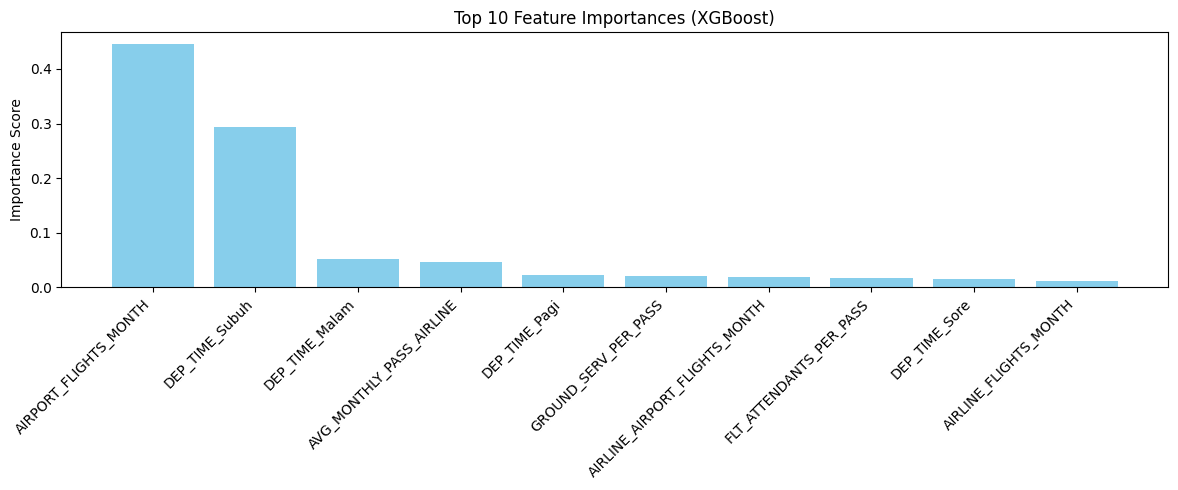

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Feature Importances ===
importances_xgb = dict(zip(X.columns, final_model.feature_importances_))
sorted_importances_xgb = sorted(importances_xgb.items(), key=lambda x: x[1], reverse=True)

print("\nTop 10 Feature Importances (XGBoost):")
for feature, importance in sorted_importances_xgb[:10]:
    print(f"{feature}: {importance:.4f}")

# Plot Top 10 Feature Importances
plt.figure(figsize=(12, 5))
plt.bar([x[0] for x in sorted_importances_xgb[:10]], [x[1] for x in sorted_importances_xgb[:10]], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Feature Importances (XGBoost)")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [7]:
for feature, importance in sorted_importances_xgb[:20]:
    print(f"{feature}: {importance:.4f}")

AIRPORT_FLIGHTS_MONTH: 0.4447
DEP_TIME_Subuh: 0.2934
DEP_TIME_Malam: 0.0522
AVG_MONTHLY_PASS_AIRLINE: 0.0472
DEP_TIME_Pagi: 0.0216
GROUND_SERV_PER_PASS: 0.0209
AIRLINE_AIRPORT_FLIGHTS_MONTH: 0.0187
FLT_ATTENDANTS_PER_PASS: 0.0176
DEP_TIME_Sore: 0.0151
AIRLINE_FLIGHTS_MONTH: 0.0123
DEP_TIME_Siang: 0.0096
SEGMENT_NUMBER: 0.0082
NUMBER_OF_SEATS: 0.0081
MONTH: 0.0064
DISTANCE_GROUP: 0.0062
DAY_OF_WEEK: 0.0060
TMAX: 0.0049
PLANE_AGE: 0.0037
DEP_DEL15: 0.0029


C:\Users\Asus\AppData\Local\Temp\ipykernel_3012\1414464013.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


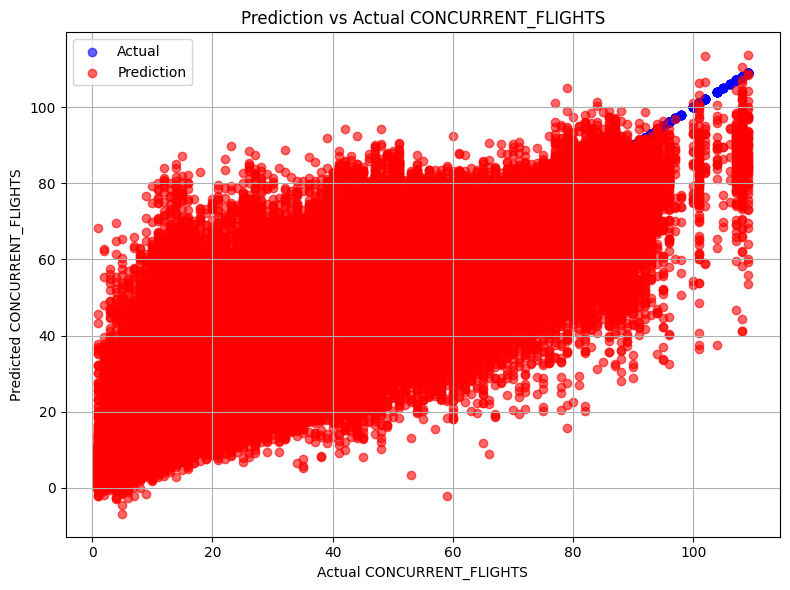

In [3]:
# === Visualization: Actual vs Predicted Scatter ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test, color='blue', label='Actual', alpha=0.6)
plt.scatter(y_test, y_pred, color='red', label='Prediction', alpha=0.6)
plt.xlabel('Actual CONCURRENT_FLIGHTS')
plt.ylabel('Predicted CONCURRENT_FLIGHTS')
plt.title('Prediction vs Actual CONCURRENT_FLIGHTS')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

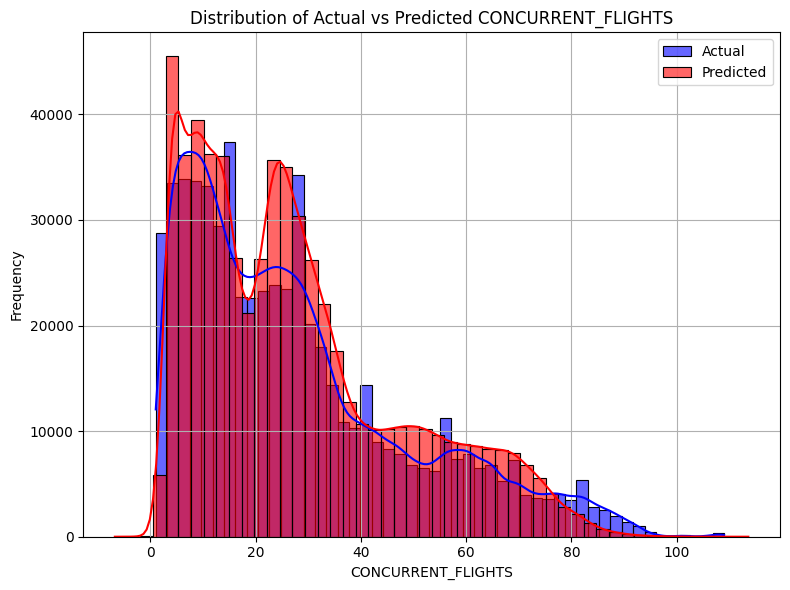

In [4]:
# === Visualization: Distribution of Actual vs Predicted ===
plt.figure(figsize=(8, 6))
sns.histplot(y_test, bins=50, kde=True, color='blue', label='Actual', alpha=0.6)
sns.histplot(y_pred, bins=50, kde=True, color='red', label='Predicted', alpha=0.6)
plt.xlabel('CONCURRENT_FLIGHTS')
plt.ylabel('Frequency')
plt.title('Distribution of Actual vs Predicted CONCURRENT_FLIGHTS')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
import joblib
joblib.dump(final_model, 'xgboost_model.pkl')  # Simpan model ke file



['xgboost_model.pkl']